Files already downloaded and verified
Epoch [1/50] | Gen Loss: 3.9458813667297363 | Disc Loss: -7.665088176727295
Epoch [2/50] | Gen Loss: 4.0724029541015625 | Disc Loss: -8.10236644744873
Epoch [3/50] | Gen Loss: 3.9875025749206543 | Disc Loss: -7.915896415710449
Epoch [4/50] | Gen Loss: 4.008589744567871 | Disc Loss: -7.903041839599609
Epoch [5/50] | Gen Loss: 3.941071033477783 | Disc Loss: -7.867631435394287
Epoch [6/50] | Gen Loss: 3.940336227416992 | Disc Loss: -7.923370361328125
Epoch [7/50] | Gen Loss: 4.078732490539551 | Disc Loss: -8.112908363342285
Epoch [8/50] | Gen Loss: 4.081080436706543 | Disc Loss: -8.115615844726562
Epoch [9/50] | Gen Loss: 4.080112457275391 | Disc Loss: -8.112396240234375
Epoch [10/50] | Gen Loss: 3.981860876083374 | Disc Loss: -8.007063865661621
Epoch [11/50] | Gen Loss: 2.2651419639587402 | Disc Loss: -5.741400718688965
Epoch [12/50] | Gen Loss: 4.074399948120117 | Disc Loss: -8.108846664428711
Epoch [13/50] | Gen Loss: 4.075231075286865 | Disc Loss:

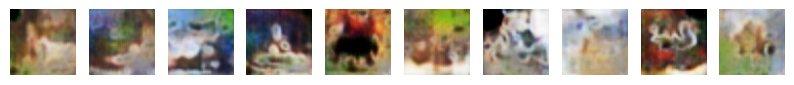

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load and preprocess CIFAR-10 dataset
def preprocess_data():
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    return dataloader

dataloader = preprocess_data()

import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim, text_dim):
        super(Generator, self).__init__()
        input_dim = noise_dim + text_dim
        self.main = nn.Sequential(
            nn.Linear(input_dim, 4 * 4 * 512),
            nn.ReLU(True),
            nn.Unflatten(1, (512, 4, 4)),
            
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, noise, text):
        x = torch.cat((noise, text), dim=1)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, text_dim):
        super(Discriminator, self).__init__()
        self.text_embed = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 1, 1))
        )
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(512 + 256, 512, kernel_size=1),
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1)  # No Sigmoid for Wasserstein loss
        )

    def forward(self, image, text):
        text_emb = self.text_embed(text).expand(-1, -1, 4, 4)
        image_features = self.main(image)
        combined = torch.cat((image_features, text_emb), dim=1)
        return self.final(combined)

import torch.optim as optim

def train_wgan(generator, discriminator, dataloader, epochs, noise_dim, text_dim, device, n_critic=5, weight_clip=0.01):
    gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    generator.to(device)
    discriminator.to(device)

    for epoch in range(epochs):
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            batch_size = images.size(0)

            # Train Discriminator
            for _ in range(n_critic):
                noise = torch.randn(batch_size, noise_dim).to(device)
                text = torch.randn(batch_size, text_dim).to(device)
                fake_images = generator(noise, text)

                disc_real = discriminator(images, text).mean()
                disc_fake = discriminator(fake_images.detach(), text).mean()
                disc_loss = -(disc_real - disc_fake)

                disc_optimizer.zero_grad()
                disc_loss.backward()
                disc_optimizer.step()

                # Weight clipping
                for p in discriminator.parameters():
                    p.data.clamp_(-weight_clip, weight_clip)

            # Train Generator
            noise = torch.randn(batch_size, noise_dim).to(device)
            text = torch.randn(batch_size, text_dim).to(device)
            fake_images = generator(noise, text)
            gen_loss = -discriminator(fake_images, text).mean()

            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}] | Gen Loss: {gen_loss.item()} | Disc Loss: {disc_loss.item()}")

import matplotlib.pyplot as plt

def generate_and_save_images(generator, epoch, noise_dim, text_dim, device, num_examples=10):
    generator.eval()
    noise = torch.randn(num_examples, noise_dim).to(device)
    text = torch.randn(num_examples, text_dim).to(device)
    fake_images = generator(noise, text).cpu().detach()

    fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]

    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(fake_images[i].permute(1, 2, 0).numpy())
        plt.axis("off")
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.show()

# Hyperparameters
noise_dim = 100
text_dim = 119
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator = Generator(noise_dim, text_dim)
discriminator = Discriminator(text_dim)

# Train models
train_wgan(generator, discriminator, dataloader, epochs, noise_dim, text_dim, device)

# Generate and save images
generate_and_save_images(generator, epochs, noise_dim, text_dim, device)


In [3]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
import numpy as np
from scipy.linalg import sqrtm
from scipy.stats import entropy

# Define Inception Score Calculation
def calculate_inception_score(images, splits=10, device="cuda"):
    """
    Calculates the Inception Score (IS) for a set of generated images.

    Args:
        images (Tensor): Tensor of generated images (N, C, H, W).
        splits (int): Number of splits for calculating the score.
        device (str): Device to run the calculations on.

    Returns:
        tuple: Mean and standard deviation of the Inception Score.
    """
    # Load pretrained Inception V3 model
    inception_model = inception_v3(pretrained=True).to(device)
    inception_model.eval()
    images = F.interpolate(images, size=(299, 299), mode="bilinear", align_corners=False)
    predictions = []

    # Generate predictions in batches
    with torch.no_grad():
        for i in range(0, len(images), 32):  # Process in batches
            batch = images[i:i + 32].to(device)
            preds = inception_model(batch)
            preds = F.softmax(preds, dim=1).cpu().numpy()
            predictions.append(preds)

    predictions = np.concatenate(predictions, axis=0)
    split_scores = []

    # Split predictions and calculate scores
    for k in range(splits):
        part = predictions[k * (len(predictions) // splits): (k + 1) * (len(predictions) // splits), :]
        py = np.mean(part, axis=0)
        scores = [entropy(pyx, py) for pyx in part]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# Define FID Calculation
def calculate_fid(real_images, fake_images, eps=1e-6):
    """
    Calculates the Frechet Inception Distance (FID) between real and fake images.

    Args:
        real_images (Tensor): Tensor of real images (N, C, H, W).
        fake_images (Tensor): Tensor of fake images (N, C, H, W).
        eps (float): Small value for numerical stability.

    Returns:
        float: FID Score.
    """
    # Load pretrained Inception V3 model
    inception_model = inception_v3(pretrained=True).to(real_images.device)
    inception_model.eval()

    def get_activations(images):
        images = F.interpolate(images, size=(299, 299), mode="bilinear", align_corners=False)
        with torch.no_grad():
            preds = []
            for i in range(0, len(images), 32):  # Process in batches
                batch = images[i:i + 32].to(real_images.device)
                pred = inception_model(batch)
                preds.append(pred)
            preds = torch.cat(preds, dim=0)
        return preds.cpu().numpy()

    # Get activations for real and fake images
    real_activations = get_activations(real_images)
    fake_activations = get_activations(fake_images)

    # Calculate mean and covariance
    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake) + eps * np.eye(sigma_real.shape[0]))

    # Handle numerical instability
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)

# Define Evaluation Function
def evaluate_metrics(generator, dataloader, noise_dim, text_dim, device):
    """
    Evaluates Inception Score and FID for the given generator.

    Args:
        generator (nn.Module): Generator model.
        dataloader (DataLoader): DataLoader for real images.
        noise_dim (int): Dimension of the noise vector.
        text_dim (int): Dimension of the text embedding vector.
        device (str): Device to run the calculations on.

    Prints:
        Inception Score and FID Score.
    """
    real_images = next(iter(dataloader))[0][:1000].to(device)  # Sample 1000 real images
    noise = torch.randn(1000, noise_dim, device=device)
    text = torch.randn(1000, text_dim, device=device)
    fake_images = generator(noise, text).to(device)

    # Compute Inception Score
    mean_is, std_is = calculate_inception_score(fake_images, device=device)
    print(f"Inception Score: {mean_is:.3f} ± {std_is:.3f}")

    # Compute FID
    fid_score = calculate_fid(real_images, fake_images)
    print(f"FID Score: {fid_score:.3f}")

# Example Usage
# Assuming `generator`, `dataloader`, `noise_dim`, `text_dim`, and `device` are already defined
evaluate_metrics(generator, dataloader, noise_dim, text_dim, device)


/home/ldusana/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ldusana/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 2.095 ± 0.092
FID Score: 863.466
